Данный ноутбук представляет собой небольшое исследование применения алгоритмов многокритериальной оптимизации для задачи оптимизации криптовалютного портфеля.

# Crypto Portfolio Optimization

In [1]:
# Библиотеки для многокритериальной оптимизации
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.algorithms.moo.ctaea import CTAEA

from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize

# Библиотека для рассчета гиперобъема
from deap.tools._hypervolume import hv

# Библиотека для рассчета расстояний между точками
from scipy.spatial.distance import pdist

# Библиотеки для работы с данными
import numpy as np
import pandas as pd
from scipy.stats import norm

# Библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотека для работы с датой и временем
from datetime import datetime, timedelta

# Библиотека для работы с информацией о криптовалютах
import yfinance as yf

sns.set_style('darkgrid')

В качестве метрики для оценки риска криптовалютного портфеля мы будем использовать его валатильность + несколько штрафных функций, чтобы алгоритм не "клал все яйца в одну корзину".


Для оценки доходности будем использовать разницу между ценой портфеля на конец периода и ценой на начало периода.

In [2]:
# Создадим функцию для получения цены на указанную дату
def get_price_on_date(ticker_symbol: str, date_str: str) -> float | None:
    try:
        date = datetime.strptime(date_str, '%Y-%m-%d')
        end_date = (date + timedelta(days=1)).strftime('%Y-%m-%d')
        
        data = yf.Ticker(ticker_symbol).history(start=date_str, end=end_date)
        
        if data.empty:
            print(f"No data available for {ticker_symbol} on {date_str}")
            return None
            
        return round(float(data['Close'].iloc[0]), 2)
    except Exception as e:
        print(f"Error fetching price for {ticker_symbol}: {e}")
        return None

In [3]:
def calculate_portfolio_price(portfolio: dict[str, float],
                            start_date: str, end_date: str, 
                            start_sum: float = 100) -> float:
    """Расчет цены портфеля на указанную дату."""
    
    portfolio_parts = {ticker: float((start_sum * part) / get_price_on_date(ticker, start_date)) 
                        for ticker, part in portfolio.items()}
    
    end_prices = {ticker: get_price_on_date(ticker, end_date) * portfolio_parts[ticker] for ticker in portfolio_parts.keys()}
    return round(sum(end_prices.values()), 2)

In [13]:
# Загрузим историю изменения цены криптовалюты

# Список интересующих криптовалют можно изменять. Все доступные тикеры можно посмотреть на https://finance.yahoo.com/crypto/
TICKERS = ["TON11419-USD", "SUI20947-USD",'ETH-USD', "LINK-USD", "APT21794-USD", "FET-USD", "TAO22974-USD", 'BTC-USD']

training_start_date = "2024-08-01"
training_end_date = "2024-08-29"

start_tocken_prices = {ticker: get_price_on_date(ticker, training_start_date) for ticker in TICKERS}
end_tocken_prices = {ticker: get_price_on_date(ticker, training_end_date) for ticker in TICKERS}

data: pd.DataFrame = yf.download(TICKERS, start=training_start_date, end=training_end_date, progress=True)["Adj Close"]
returns: pd.DataFrame = data.pct_change().dropna()

# Для рассчета ожидаемой доходности и ковариационной матрицы используется средняя доходность
expected_returns: pd.Series = returns.mean()
cov_matrix: pd.DataFrame = returns.cov()

[*********************100%***********************]  8 of 8 completed


In [15]:
# Класс для решения задачи многокритериальной оптимизации криптовалютного портфеля
class CryptoPortfolioProblem(ElementwiseProblem):
    """Задача многокритериальной оптимизации криптовалютного портфеля."""
    
    START_PRICE = 1000.0
    
    def __init__(self, 
                elementwise=True, 
                **kwargs):
        """
        Инициализация задачи оптимизации.
        
        Args:
            elementwise (bool): Флаг поэлементной оценки
            confidence_level (float): Уровень доверия для VaR
            **kwargs: Дополнительные параметры
        """
        n_assets = len(TICKERS)
        
        # Предварительный расчет статических данных
        self._precompute_data()
        
        super().__init__(
            elementwise=elementwise,
            n_var=n_assets,
            n_obj=2,
            xl=0,
            xu=1
        )

    def _precompute_data(self):
        """Предварительный расчет данных для оптимизации производительности."""
        self.start_token_prices = np.array([start_tocken_prices[ticker] for ticker in TICKERS])
        self.end_token_prices = np.array([end_tocken_prices[ticker] for ticker in TICKERS])
        self.cov_matrix = cov_matrix.values

    @staticmethod
    def _normalize_weights(x: np.ndarray) -> np.ndarray:
        """Нормализация весов портфеля."""
        return x / np.sum(x)

    def _evaluate(self, x: np.ndarray, out: dict, *args, **kwargs) -> None:
        """
        Оценка целевых функций.
        
        Args:
            x: Веса портфеля
            out: Словарь результатов
        """
        weights = self._normalize_weights(x)
        profit = self._calc_portfolio_return(weights)
        risk = self._calc_volatility(weights)
        
        out["F"] = [-profit, risk]

    def _calc_portfolio_return(self, weights: np.ndarray) -> float:
        """Расчет доходности портфеля."""
        portfolio_units = weights * self.START_PRICE / self.start_token_prices
        end_value = np.sum(portfolio_units * self.end_token_prices)
        return end_value - self.START_PRICE

    def _calc_volatility(self, weights: np.ndarray) -> float:
        """Расчет волатильности портфеля."""
        return np.sqrt(weights.T @ self.cov_matrix @ weights)
            
problem = CryptoPortfolioProblem()

# Применяем алгоритмы многокритериальной оптимизации

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      150 |      5 |             - |             -
     2 |      300 |      2 |  0.0675670873 |         ideal
     3 |      450 |      5 |  0.2430711256 |         ideal
     4 |      600 |      3 |  0.1495722593 |         ideal
     5 |      750 |      7 |  0.1596941328 |         ideal
     6 |      900 |      5 |  0.6353350744 |         ideal
     7 |     1050 |      1 |  9.9781575373 |         ideal
     8 |     1200 |      2 |  1.6433336158 |         ideal
     9 |     1350 |      3 |  0.5686321726 |         ideal
    10 |     1500 |      6 |  0.3914804515 |         ideal
    11 |     1650 |      6 |  0.6872622094 |         ideal
    12 |     1800 |      4 |  0.2194513371 |         ideal
    13 |     1950 |      6 |  0.3516941846 |         ideal
    14 |     2100 |      5 |  0.4045403307 |         ideal
    15 |     2250 |      3 |  1.3148050156 |         ideal
    16 |     2400 |      3 |  0.9285651164 |         ide

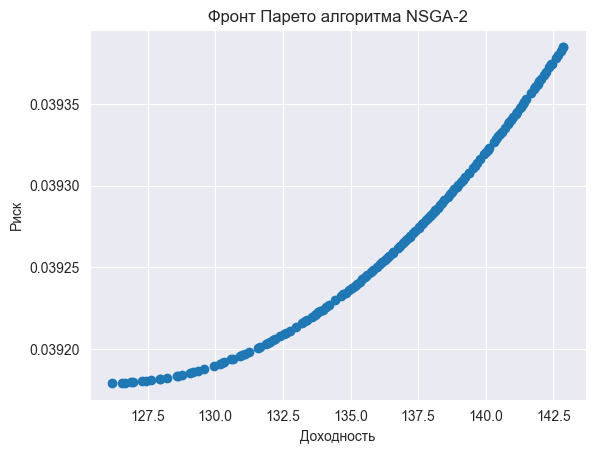

In [16]:
# Первый алгоритм, который мы протестируем - это NSGA-2.
# В данном случае мы не используем параметры по умолчанию, а явно задаем размер популяции и количество поколений

nsga2 = NSGA2(pop_size=150)
mutation = PolynomialMutation(eta=20, prob_var=0.2)

nsga2_result = minimize(
    problem,
    nsga2,
    ('n_gen', 1500),
    verbose=True,
    mutation=mutation
)

# Визуализируем результаты
plt.scatter(-nsga2_result.F[:, 0], nsga2_result.F[:, 1])
plt.xlabel("Доходность")
plt.ylabel("Риск")
plt.title("Фронт Парето алгоритма NSGA-2")
plt.show()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       51 |      5 |             - |             -
     2 |      102 |     49 |  1.3534987963 |         ideal
     3 |      153 |     21 |  0.0896786947 |         ideal
     4 |      204 |     21 |  0.1173917817 |         ideal
     5 |      255 |     37 |  0.0533700710 |         ideal
     6 |      306 |     41 |  0.1626324166 |         ideal
     7 |      357 |     20 |  1.936809E+01 |         ideal
     8 |      408 |     31 |  0.9823146718 |         ideal
     9 |      459 |     22 |  5.488798E+05 |         ideal
    10 |      510 |     20 |  6.2541891800 |         ideal
    11 |      561 |     21 |  7.0912748876 |         ideal
    12 |      612 |     20 |  2.597965E+02 |         ideal
    13 |      663 |     20 |  6.3709320165 |         ideal
    14 |      714 |     20 |  4.6227830318 |         ideal
    15 |      765 |     25 |  1.7132156753 |         ideal
    16 |      816 |     21 |  4.2885973389 |         ide

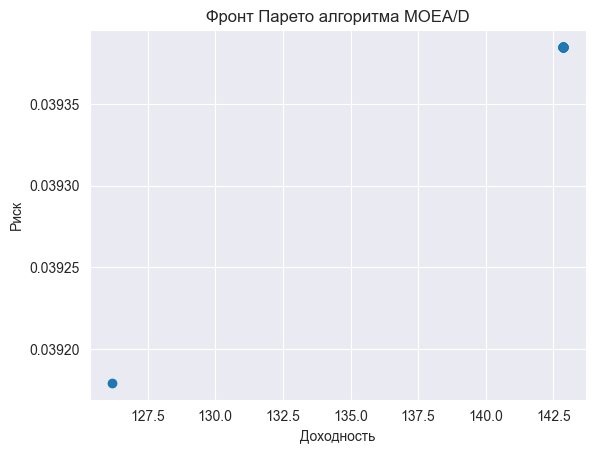

In [18]:
# Второй алгоритм, который мы протестируем - это MOEA/D.

# get_reference_directions генерирует направления для поиска MOEA/D
ref_dirs = get_reference_directions('uniform', 2, n_partitions=50)

moea_d = MOEAD(
    ref_dirs,
    n_neighbors=20,
)

moea_d_result = minimize(problem,
            moea_d,
            ('n_gen', 1500),
            verbose=True
            )

plt.scatter(-moea_d_result.F[:, 0], moea_d_result.F[:, 1])
plt.xlabel("Доходность")
plt.ylabel("Риск")
plt.title("Фронт Парето алгоритма MOEA/D")
plt.show()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       51 |      4 |             - |             -
     2 |      102 |      4 |  0.0636889572 |         ideal
     3 |      153 |      6 |  0.0200422910 |             f
     4 |      204 |      1 |  2.322936E+01 |         ideal
     5 |      255 |      1 |  0.000000E+00 |             f
     6 |      306 |      3 |  0.5234484224 |         ideal
     7 |      357 |      4 |  0.9971753299 |         ideal
     8 |      408 |      4 |  0.3552151788 |         ideal
     9 |      459 |      4 |  0.2784974754 |         ideal
    10 |      510 |      4 |  0.2312617425 |         ideal
    11 |      561 |      3 |  0.2318644269 |         ideal
    12 |      612 |      4 |  0.2636090787 |         ideal
    13 |      663 |      4 |  0.2963300940 |         ideal
    14 |      714 |      2 |  1.7839002828 |         ideal
    15 |      765 |      3 |  0.5804486239 |         ideal
    16 |      816 |      3 |  2.5883392868 |         ide

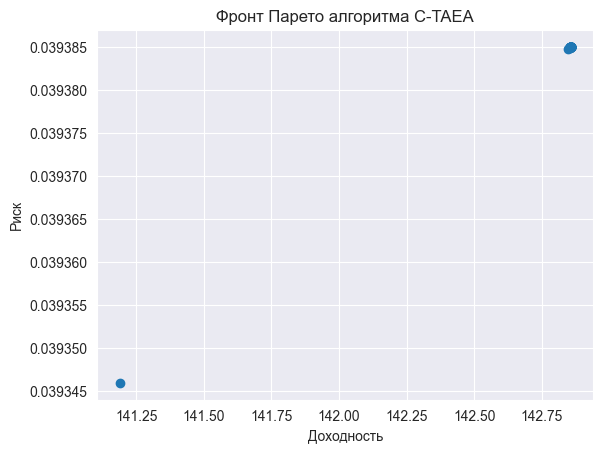

In [19]:
# Третий алгоритм, который мы протестируем - это C-TAEA.

ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=50)

c_taea = CTAEA(ref_dirs=ref_dirs)

c_taea_res = minimize(problem,
            c_taea,
            ('n_gen', 1500),
            verbose=True
            )

plt.scatter(-c_taea_res.F[:, 0], c_taea_res.F[:, 1])
plt.xlabel("Доходность")
plt.ylabel("Риск")
plt.title("Фронт Парето алгоритма C-TAEA")
plt.show()

# Оценка полученных Парето-фронтов

In [20]:
def calculate_common_reference_point(pareto_fronts: list, margin: float = 0.1, min_margin: float = 0.01) -> np.ndarray:
    """
    Вычисляет общую референсную точку для нескольких Парето-фронтов с учётом минимального запаса.

    Аргументы:
    - pareto_fronts: list - список массивов np.ndarray, где каждый массив представляет Парето-фронт
        (размерность каждого массива: n_points x n_objectives).
    - margin: float - относительный запас, добавляемый к максимальным значениям целевых функций.
    - min_margin: float - минимальный гарантированный запас, добавляемый к каждой цели (в абсолютных величинах).

    Возвращает:
    - np.ndarray - общая референсная точка (массив размерности n_objectives).
    """
    # Объединяем все Парето-фронты в один массив
    all_points = np.vstack(pareto_fronts)

    # Находим максимальные значения для каждой целевой функции
    max_values = np.max(all_points, axis=0)
    min_values = np.min(all_points, axis=0)

    # Вычисляем диапазоны
    ranges = max_values - min_values

    # Референсная точка с учётом запаса
    reference_point = max_values + np.maximum(margin * ranges, min_margin)

    return reference_point

In [21]:
reference_point = calculate_common_reference_point([nsga2_result.F, moea_d_result.F, c_taea_res.F])

Превоначально применим метрику Hypervolume для оценки качества полученных Парето-фронтов.
В качестве reference point возьмём точку с отрицательной доходностью (-0.5) и высоким риском (1.0)

In [22]:
print('NSGA-2 hypervolume: ', hv.hypervolume(nsga2_result.F, reference_point))  
print('MOEA/D hypervolume: ', hv.hypervolume(moea_d_result.F, reference_point))
print('C-TAEA hypervolume: ', hv.hypervolume(c_taea_res.F, reference_point))

NSGA-2 hypervolume:  0.18600461532147228
MOEA/D hypervolume:  0.18373495243081334
C-TAEA hypervolume:  0.18403882754812068


Теперь применим метрику Spacing для оценки расстояния между точками Парето-фронта.

In [35]:
def spacing(points: np.ndarray) -> float:
    distances = np.zeros(len(points))
    for i, point in enumerate(points):
        other_points = np.delete(points, i, axis=0)
        distances[i] = np.min(np.linalg.norm(other_points - point, axis=1))
    # Среднее расстояние
    mean_distance = np.mean(distances)
    # Вычисление Spacing
    spacing = np.sqrt(np.mean((distances - mean_distance) ** 2))
    return spacing

print('NSGA-2 spacing: ', spacing(nsga2_result.F))
print('MOEA/D spacing: ', spacing(moea_d_result.F))
print('C-TAEA spacing: ', spacing(c_taea_res.F))

NSGA-2 spacing:  0.048365039738453984
MOEA/D spacing:  2.309975064051408
C-TAEA spacing:  0.22983436867642323


И теперь рассчитаем среднее евклидово расстояние между точками Парето-фронта для оценки разнообразия Парето-фронтов.

In [24]:
def average_distance(points: np.ndarray) -> float:
    distances = pdist(points, metric='euclidean')
    return np.mean(distances)

print('NSGA-2 average distance: ', average_distance(nsga2_result.X))
print('MOEA/D average distance: ', average_distance(moea_d_result.X))
print('C-TAEA average distance: ', average_distance(c_taea_res.X))

NSGA-2 average distance:  0.15020661091660165
MOEA/D average distance:  0.07417365587825786
C-TAEA average distance:  0.12524342800951252


# Анализ предоставленных решений

In [25]:
# Сейчас решение представлено в виде чисел от 0 до 10. Нам нужно нормализовать их так, чтобы их сумма равнялась 1.
def normalize_weights(weights: np.ndarray) -> np.ndarray:
    res = np.round(weights / weights.sum(axis=1)[:, np.newaxis], 3)
    return res

In [26]:
# Соберём данные в единую таблицу

nsga2_data = pd.DataFrame(normalize_weights(nsga2_result.X), columns=TICKERS)\
    .drop_duplicates()\
    .merge(pd.DataFrame(nsga2_result.F, columns=['expected_profit', 'risk']), left_index=True, right_index=True)
nsga2_data['algorithm'] = 'NSGA-2'

moea_d_data = pd.DataFrame(normalize_weights(moea_d_result.X), columns=TICKERS)\
    .drop_duplicates()\
    .merge(pd.DataFrame(moea_d_result.F, columns=['expected_profit', 'risk']), left_index=True, right_index=True)
moea_d_data['algorithm'] = 'MOEA/D'

c_taea_data = pd.DataFrame(normalize_weights(c_taea_res.X), columns=TICKERS)\
    .drop_duplicates()\
    .merge(pd.DataFrame(c_taea_res.F, columns=['expected_profit', 'risk']), left_index=True, right_index=True)
c_taea_data['algorithm'] = 'C-TAEA'

all_data = pd.concat([nsga2_data, moea_d_data, c_taea_data])
all_data['expected_profit'] = -all_data['expected_profit']
all_data

,TON11419-USD,SUI20947-USD,ETH-USD,LINK-USD,APT21794-USD,FET-USD,TAO22974-USD,BTC-USD,expected_profit,risk,algorithm
0,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.000,142.857143,0.039385,NSGA-2
1,0.0,0.929,0.0,0.0,0.0,0.0,0.0,0.071,126.185550,0.039179,NSGA-2
3,0.0,0.937,0.0,0.0,0.0,0.0,0.0,0.063,128.211365,0.039182,NSGA-2
4,0.0,0.963,0.0,0.0,0.0,0.0,0.0,0.037,134.214074,0.039227,NSGA-2
5,0.0,0.989,0.0,0.0,0.0,0.0,0.0,0.011,140.298405,0.039327,NSGA-2
...,...,...,...,...,...,...,...,...,...,...,...
140,0.0,0.959,0.0,0.0,0.0,0.0,0.0,0.041,133.196825,0.039216,NSGA-2
0,0.0,0.929,0.0,0.0,0.0,0.0,0.0,0.071,126.186198,0.039179,MOEA/D
1,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.000,142.847069,0.039385,MOEA/D
0,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.000,142.857037,0.039385,C-TAEA


In [27]:
all_data.groupby('algorithm', as_index=False).mean()

,algorithm,TON11419-USD,SUI20947-USD,ETH-USD,LINK-USD,APT21794-USD,FET-USD,TAO22974-USD,BTC-USD,expected_profit,risk
0,C-TAEA,0.0,0.996500,0.0,0.0,0.0,0.0,0.0,0.003500,142.023118,0.039366
1,MOEA/D,0.0,0.964500,0.0,0.0,0.0,0.0,0.0,0.035500,134.516634,0.039282
2,NSGA-2,0.0,0.965853,0.0,0.0,0.0,0.0,0.0,0.034147,134.858086,0.039252


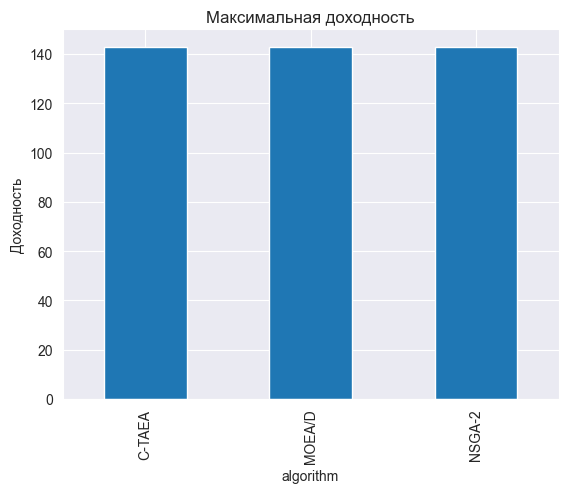

In [28]:
all_data.groupby('algorithm')['expected_profit'].max().plot(kind='bar')
plt.title('Максимальная доходность')
plt.ylabel('Доходность')

plt.show()

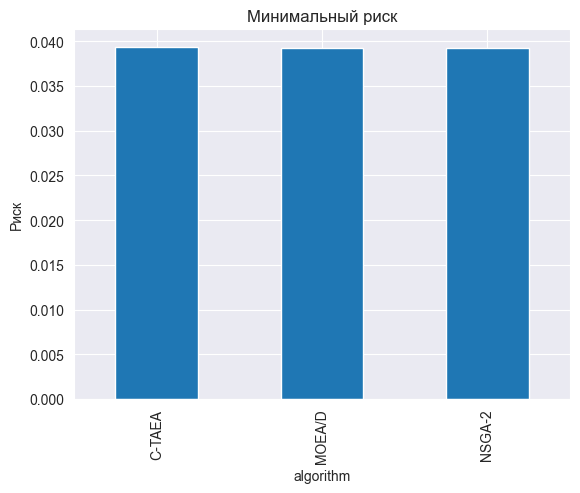

In [29]:
all_data.groupby('algorithm')['risk'].min().plot(kind='bar')
plt.title('Минимальный риск')
plt.ylabel('Риск')
plt.show()

In [30]:
all_data['end_price'] = all_data.apply(lambda row: calculate_portfolio_price(row[TICKERS].to_dict(), '2024-11-01', '2024-12-02'), axis=1)
all_data

,TON11419-USD,SUI20947-USD,ETH-USD,LINK-USD,APT21794-USD,FET-USD,TAO22974-USD,BTC-USD,expected_profit,risk,algorithm,end_price
0,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.000,142.857143,0.039385,NSGA-2,163.32
1,0.0,0.929,0.0,0.0,0.0,0.0,0.0,0.071,126.185550,0.039179,NSGA-2,161.50
3,0.0,0.937,0.0,0.0,0.0,0.0,0.0,0.063,128.211365,0.039182,NSGA-2,161.71
4,0.0,0.963,0.0,0.0,0.0,0.0,0.0,0.037,134.214074,0.039227,NSGA-2,162.37
5,0.0,0.989,0.0,0.0,0.0,0.0,0.0,0.011,140.298405,0.039327,NSGA-2,163.04
...,...,...,...,...,...,...,...,...,...,...,...,...
140,0.0,0.959,0.0,0.0,0.0,0.0,0.0,0.041,133.196825,0.039216,NSGA-2,162.27
0,0.0,0.929,0.0,0.0,0.0,0.0,0.0,0.071,126.186198,0.039179,MOEA/D,161.51
1,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.000,142.847069,0.039385,MOEA/D,163.32
0,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.000,142.857037,0.039385,C-TAEA,163.32


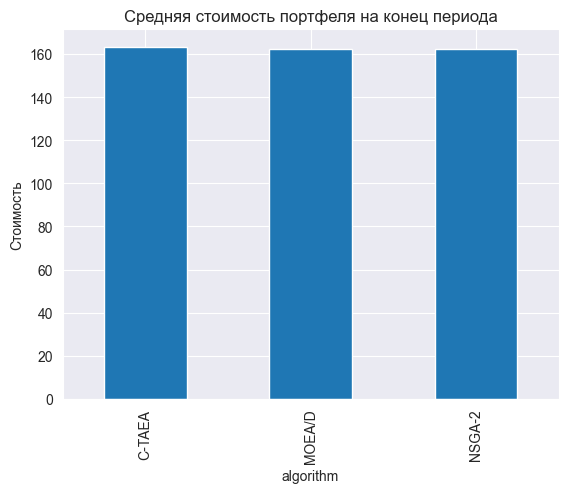

In [31]:
all_data.groupby('algorithm')['end_price'].mean().plot(kind='bar')
plt.title('Средняя стоимость портфеля на конец периода')
plt.ylabel('Стоимость')
plt.show()

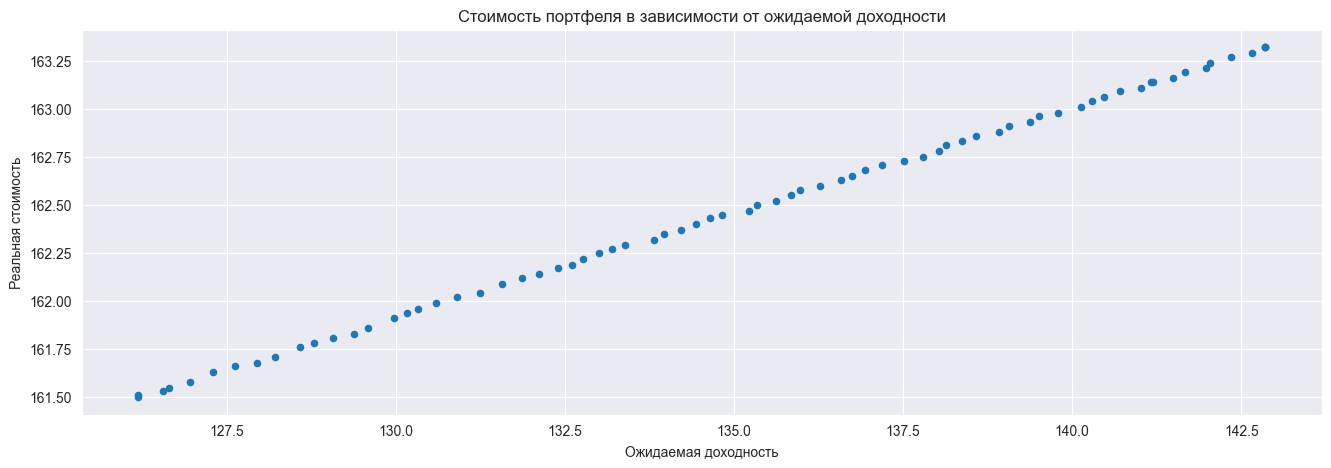

In [32]:
all_data.sort_values(by='end_price', ascending=False)[['expected_profit', 'end_price']]\
    .plot(kind='scatter', x='expected_profit', y='end_price', figsize=(16, 5))
plt.title('Стоимость портфеля в зависимости от ожидаемой доходности')
plt.xlabel('Ожидаемая доходность')
plt.ylabel('Реальная стоимость')
plt.show()

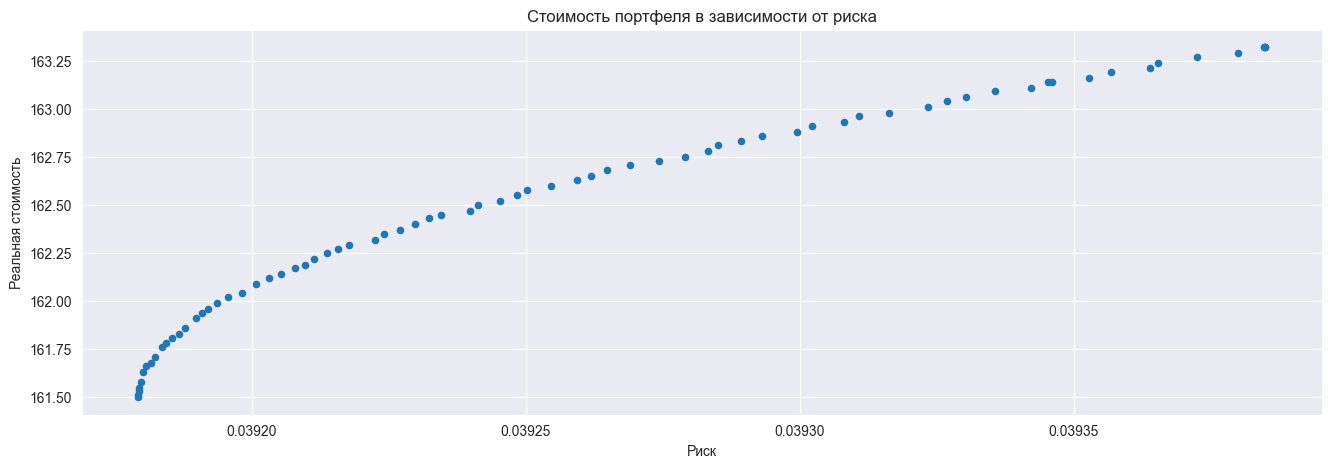

In [33]:
all_data.sort_values(by='end_price', ascending=False)[['risk', 'end_price']]\
    .plot(kind='scatter', x='risk', y='end_price', figsize=(16, 5))
plt.title('Стоимость портфеля в зависимости от риска')
plt.xlabel('Риск')
plt.ylabel('Реальная стоимость')
plt.show()

In [36]:
all_data.sort_values(by='end_price', ascending=False)

,TON11419-USD,SUI20947-USD,ETH-USD,LINK-USD,APT21794-USD,FET-USD,TAO22974-USD,BTC-USD,expected_profit,risk,algorithm,end_price
0,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.000,142.857143,0.039385,NSGA-2,163.32
1,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.000,142.847069,0.039385,MOEA/D,163.32
0,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.000,142.857037,0.039385,C-TAEA,163.32
50,0.0,0.999,0.0,0.0,0.0,0.0,0.0,0.001,142.655782,0.039380,NSGA-2,163.29
84,0.0,0.998,0.0,0.0,0.0,0.0,0.0,0.002,142.342541,0.039373,NSGA-2,163.27
...,...,...,...,...,...,...,...,...,...,...,...,...
23,0.0,0.932,0.0,0.0,0.0,0.0,0.0,0.068,126.955495,0.039180,NSGA-2,161.58
71,0.0,0.931,0.0,0.0,0.0,0.0,0.0,0.069,126.641495,0.039179,NSGA-2,161.55
59,0.0,0.930,0.0,0.0,0.0,0.0,0.0,0.070,126.551525,0.039179,NSGA-2,161.53
0,0.0,0.929,0.0,0.0,0.0,0.0,0.0,0.071,126.186198,0.039179,MOEA/D,161.51
